In [102]:

# Full script with corrected bounds/center/index block
# Requires: geopandas, shapely, networkx, numpy, matplotlib, fiona, pyproj, pandas
import geopandas as gpd
import networkx as nx
import numpy as np
from shapely.geometry import box
import matplotlib.pyplot as plt
import os
import pandas as pd

INPUT_KML = "squadrats-2025-11-03.kml"   # replace or point to uploaded file
OUT_DIR = "yardinho_output"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) load file (try KML driver; GeoPandas can usually read KML/KMZ)
try:
    gdf = gpd.read_file(INPUT_KML, driver="KML")
except Exception as e:
    # fallback automatic read
    gdf = gpd.read_file(INPUT_KML)

if gdf.empty:
    raise SystemExit("Input file contains no features. Check the layer or file.")

# If the features are points, buffer to polygon by cell size estimate (rare)
if gdf.geometry.iloc[0].geom_type == "Point":
    # estimate spacing from distances between points
    pts = gdf.geometry.centroid
    if len(pts) > 1:
        dists = []
        coords = np.array([p.coords[0] for p in pts])
        for i in range(1, min(len(coords), 200)):
            dists.append(np.hypot(*(coords[i] - coords[0])))
        approx = np.median(dists) if dists else 10
    else:
        approx = 10
    gdf['geometry'] = gdf.geometry.buffer(approx/2)


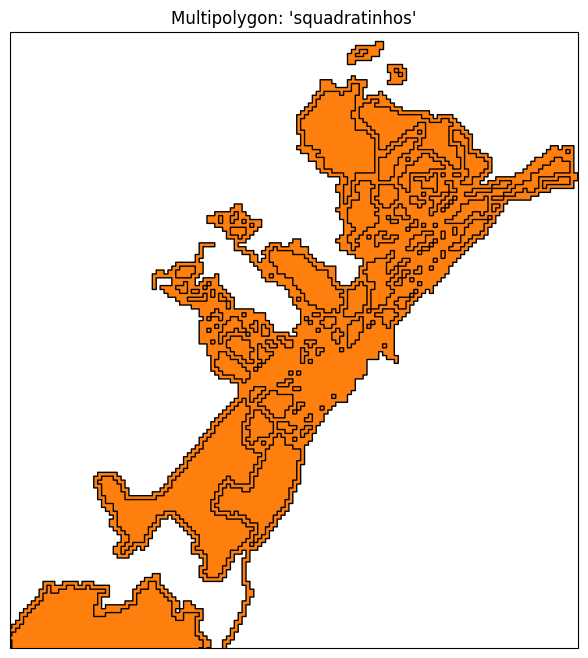

In [104]:
gdf_squads = gdf[(gdf['Name'] == 'squadratinhos')]
gdf_ll = gdf_squads.to_crs(epsg=4326)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
gdf_ll.plot(ax=ax, color='tab:orange', edgecolor='k', transform=ccrs.PlateCarree())

# Set bounds (Swiss lon/lat)
ax.set_xlim([6, 6.4])
ax.set_ylim([46.25, 46.55])

ax.set_title("Multipolygon: 'squadratinhos'")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("yardinho_output/squadratinhos_plot.png", dpi=200, bbox_inches='tight')


Analysis bounds: [6.0, 46.25, 6.4, 46.55]

Analyzing existing squadratinhos to determine grid structure...
Found 127 individual polygons
Detected cell size: 0.024719° lon x 0.020642° lat
Cell size in meters: ~1897.7m x 2297.9m
Grid origin offset: 0.010996° lon, 0.010159° lat

Grid size: 15 rows x 17 cols = 255 cells

Discretizing map into grid...

Total squadratinhos in region: 3
Coverage: 1.18%


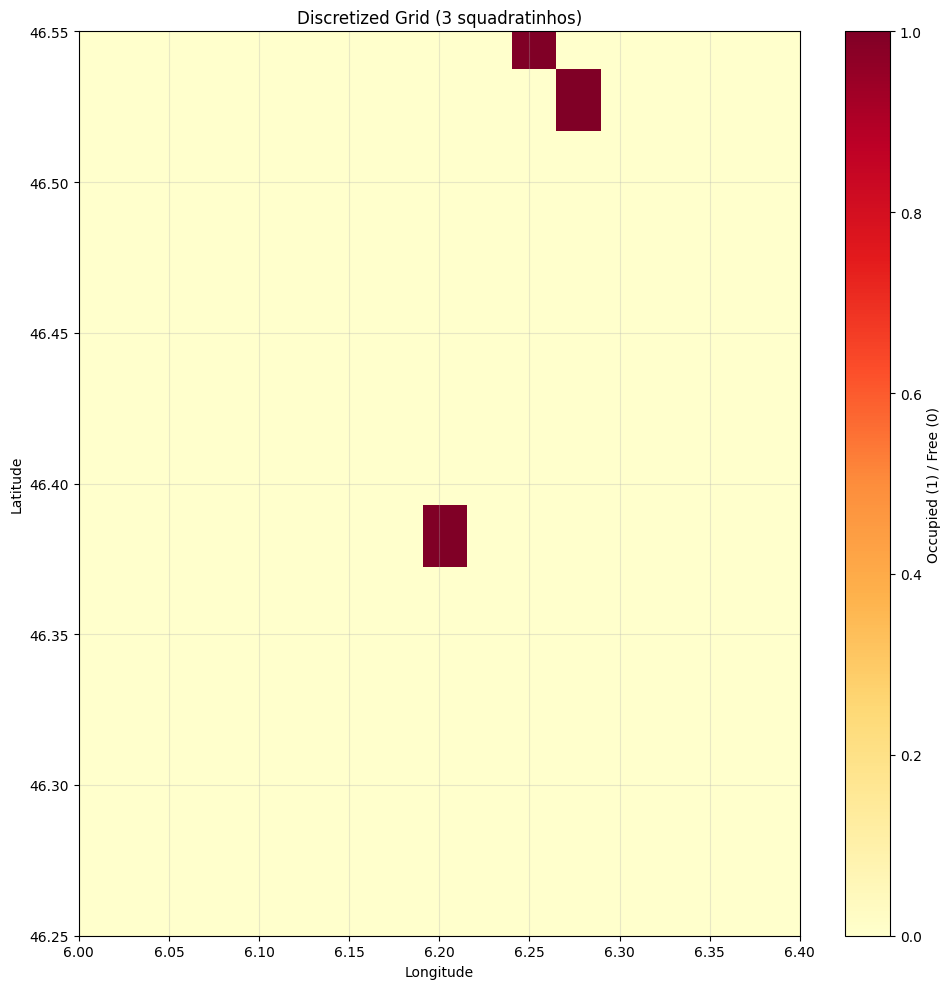


Results saved to 'yardinho_output/' directory
- grid.npy: Binary grid (1=squadratinho, 0=free)
- grid_edges.npz: Grid edge coordinates
- aligned_grid.png: Visualization

Ready for cluster analysis!


In [107]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
from scipy.ndimage import label
import os
import pandas as pd

INPUT_KML = "squadrats-2025-11-03.kml"
OUT_DIR = "yardinho_output"
os.makedirs(OUT_DIR, exist_ok=True)

# Load KML file
try:
    gdf = gpd.read_file(INPUT_KML, driver="KML")
except Exception:
    gdf = gpd.read_file(INPUT_KML)

if gdf.empty:
    raise SystemExit("Input file contains no features.")

# Filter for 'squadratinhos'
gdf_squads = gdf[gdf['Name'] == 'squadratinhos'].copy()
if gdf_squads.empty:
    raise SystemExit("No 'squadratinhos' found in the file.")

# Convert to lat/lon (EPSG:4326)
gdf_ll = gdf_squads.to_crs(epsg=4326)

# Use specified bounds for analysis
BOUNDS = [6.0, 46.25, 6.4, 46.55]  # [minx, miny, maxx, maxy]
print(f"Analysis bounds: {BOUNDS}")

# Step 1: Discover the actual grid structure from existing squadratinhos
print("\nAnalyzing existing squadratinhos to determine grid structure...")

# Extract all individual polygons from the multipolygon
cell_sizes_lon = []
cell_sizes_lat = []
all_polygons = []

for geom in gdf_ll.geometry:
    if geom.geom_type == 'Polygon':
        all_polygons.append(geom)
        b = geom.bounds
        cell_sizes_lon.append(b[2] - b[0])
        cell_sizes_lat.append(b[3] - b[1])
    elif geom.geom_type == 'MultiPolygon':
        for poly in geom.geoms:
            all_polygons.append(poly)
            b = poly.bounds
            cell_sizes_lon.append(b[2] - b[0])
            cell_sizes_lat.append(b[3] - b[1])

print(f"Found {len(all_polygons)} individual polygons")

cell_size_lon = np.median(cell_sizes_lon)
cell_size_lat = np.median(cell_sizes_lat)

print(f"Detected cell size: {cell_size_lon:.6f}° lon x {cell_size_lat:.6f}° lat")
print(f"Cell size in meters: ~{cell_size_lon * 111320 * np.cos(np.radians(46.4)):.1f}m x {cell_size_lat * 111320:.1f}m")

# Step 2: Find grid origin by looking at the lower-left corner of squadratinhos
corners_lon = []
corners_lat = []

for poly in all_polygons:
    b = poly.bounds
    corners_lon.append(b[0])
    corners_lat.append(b[1])

# Find the grid origin (should align all cells)
# Use modulo to find the offset
if len(corners_lon) > 0:
    lon_offsets = np.array(corners_lon) % cell_size_lon
    lat_offsets = np.array(corners_lat) % cell_size_lat
    
    grid_origin_lon = np.median(lon_offsets)
    grid_origin_lat = np.median(lat_offsets)
else:
    grid_origin_lon = 0
    grid_origin_lat = 0

print(f"Grid origin offset: {grid_origin_lon:.6f}° lon, {grid_origin_lat:.6f}° lat")

# Step 3: Create aligned grid for the specified bounds
# Snap bounds to grid
min_lon = BOUNDS[0] - (BOUNDS[0] - grid_origin_lon) % cell_size_lon
min_lat = BOUNDS[1] - (BOUNDS[1] - grid_origin_lat) % cell_size_lat
max_lon = BOUNDS[2]
max_lat = BOUNDS[3]

lon_edges = np.arange(min_lon, max_lon + cell_size_lon, cell_size_lon)
lat_edges = np.arange(min_lat, max_lat + cell_size_lat, cell_size_lat)

n_rows = len(lat_edges) - 1
n_cols = len(lon_edges) - 1

print(f"\nGrid size: {n_rows} rows x {n_cols} cols = {n_rows * n_cols} cells")

# Step 4: Create binary grid (1 = squadratinho, 0 = free)
print("\nDiscretizing map into grid...")
grid = np.zeros((n_rows, n_cols), dtype=np.uint8)

# Create a set of polygon bounds for faster lookup
polygon_cells = set()
for poly in all_polygons:
    # Find which grid cell this polygon belongs to
    centroid = poly.centroid
    if (centroid.x >= lon_edges[0] and centroid.x <= lon_edges[-1] and
        centroid.y >= lat_edges[0] and centroid.y <= lat_edges[-1]):
        # Find grid indices
        j = int((centroid.x - lon_edges[0]) / cell_size_lon)
        i = int((centroid.y - lat_edges[0]) / cell_size_lat)
        if 0 <= i < n_rows and 0 <= j < n_cols:
            polygon_cells.add((i, j))

# Fill the grid
for (i, j) in polygon_cells:
    grid[i, j] = 1

occupied_count = np.sum(grid)
print(f"\nTotal squadratinhos in region: {occupied_count}")
print(f"Coverage: {100 * occupied_count / total_cells:.2f}%")

# Save grid data
np.save(os.path.join(OUT_DIR, 'grid.npy'), grid)
np.savez(os.path.join(OUT_DIR, 'grid_edges.npz'), 
         lon_edges=lon_edges, lat_edges=lat_edges)

# Visualization
fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(grid, cmap='YlOrRd', origin='lower', 
               extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]],
               interpolation='nearest', aspect='auto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Discretized Grid ({occupied_count} squadratinhos)')
ax.set_xlim(BOUNDS[0], BOUNDS[2])
ax.set_ylim(BOUNDS[1], BOUNDS[3])
ax.grid(True, alpha=0.3)
plt.colorbar(im, ax=ax, label='Occupied (1) / Free (0)')

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'aligned_grid.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nResults saved to '{OUT_DIR}/' directory")
print("- grid.npy: Binary grid (1=squadratinho, 0=free)")
print("- grid_edges.npz: Grid edge coordinates")
print("- aligned_grid.png: Visualization")
print("\nReady for cluster analysis!")